In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import yaml
import pypsa

from pypsa.descriptors import Dict
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

from cartopy import crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from geopandas.tools import geocode

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import calendar
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

from math import radians, cos, sin, asin, sqrt

In [3]:
def load_configuration(config_path):
    """
    Load configuration settings from a YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


snakemake = Dict()
snakemake.config = load_configuration("../config.yaml")
snakemake.input = Dict()
snakemake.output = Dict()

run = "test-distances2-1H-allflex-noexcess-nocostshifts"  # run name from config.yaml
distance = "IEDK"  # pair name from config.yaml

if True:
    folder = f"/results/{run}"
    scenario = f"/2025/p1/cfe100/{distance}"

    snakemake.input.data = f"{folder}/networks/{scenario}/40.nc"
    snakemake.output.plot = f"{folder}/plots/plot.pdf"

    n = pypsa.Network(f"../{folder}/networks/{scenario}/40.nc")

INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
config = snakemake.config
policy = "cfe100"
palette = "p1"
zone = snakemake.config["zone"]
year = "2025"
datacenters = config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())

flexibilities = snakemake.config["scenario"]["flexibility"]

### Helper functions


In [5]:
def retrieve_nb(n, node, rename={}):
    """
    Retrieve nodal energy balance per hour
        -> lines and links are bidirectional AND their subsets are exclusive.
        -> links include fossil gens
    NB {-1} multiplier is a nodal balance sign
    """

    components = ["Generator", "Load", "StorageUnit", "Store", "Link", "Line"]
    nodal_balance = pd.DataFrame(index=n.snapshots)

    for i in components:
        if i == "Generator":
            node_generators = n.generators.query("bus==@node").index
            nodal_balance = nodal_balance.join(n.generators_t.p[node_generators])
        if i == "Load":
            node_loads = n.loads.query("bus==@node").index
            nodal_balance = nodal_balance.join(-1 * n.loads_t.p_set[node_loads])
        if i == "Link":
            node_export_links = n.links.query("bus0==@node").index
            node_import_links = n.links.query("bus1==@node").index
            nodal_balance = nodal_balance.join(-1 * n.links_t.p0[node_export_links])
            nodal_balance = nodal_balance.join(-1 * n.links_t.p1[node_import_links])
            ##################
        if i == "StorageUnit":
            # node_storage_units = n.storage_units.query('bus==@node').index
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_dispatch[node_storage_units])
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_store[node_storage_units])
            continue
        if i == "Line":
            continue
        if i == "Store":
            continue

    nodal_balance = nodal_balance.rename(columns=rename).groupby(level=0, axis=1).sum()

    # Custom groupby function
    def custom_groupby(column_name):
        if column_name.startswith("vcc"):
            return "spatial shift"
        return column_name

    # Apply custom groupby function
    nodal_balance = nodal_balance.groupby(custom_groupby, axis=1).sum()

    # revert nodal balance sign for display
    if "spatial shift" in nodal_balance.columns:
        nodal_balance["spatial shift"] = nodal_balance["spatial shift"] * -1
    if "temporal shift" in nodal_balance.columns:
        nodal_balance["temporal shift"] = nodal_balance["temporal shift"] * -1

    return nodal_balance

In [71]:
def analyze_datacenter_shifts(n, dc1, dc2):
    """
    Analyze the shifts in energy feed-in and spatial shift for two datacenters.

    :param n: PyPSA Network object
    :param dc1: Name of the first datacenter
    :param dc2: Name of the second datacenter
    :return: Dictionary with analysis results

    NB Positive shift -> sending jobs away; negative shift -> receiving jobs
    """

    # retrieve datacenter data
    def analyze_dc(dc_name):
        feedin = retrieve_nb(n, dc_name)[[f"{dc_name} onwind", f"{dc_name} solar"]]
        curtailment = hourly_curtailment(n, "onwind", [dc_name]) + hourly_curtailment(
            n, "solar", [dc_name]
        )
        spatial_shift = None
        if "spatial shift" in retrieve_nb(n, dc_name):
            spatial_shift = retrieve_nb(n, dc_name)["spatial shift"]

        return {
            "feedin": feedin,
            "curtailment": curtailment,
            "spatial_shift": spatial_shift,
        }

    # Analyze both datacenters
    dc1_analysis = analyze_dc(dc1)
    dc2_analysis = analyze_dc(dc2)

    # Collect and store wind and solar hourly potentials
    potentials_dc1 = n.generators_t.p_max_pu[[f"{dc1} onwind", f"{dc1} solar"]]
    potentials_dc2 = n.generators_t.p_max_pu[[f"{dc2} onwind", f"{dc2} solar"]]

    # Compute differences between wind and solar feed-in
    diff_onwind = (
        dc1_analysis["feedin"][f"{dc1} onwind"]
        - dc2_analysis["feedin"][f"{dc2} onwind"]
    )
    diff_solar = (
        dc1_analysis["feedin"][f"{dc1} solar"] - dc2_analysis["feedin"][f"{dc2} solar"]
    )

    # Compute differences between wind and solar potentials
    diff_onwind_potential = (
        potentials_dc1[f"{dc1} onwind"] - potentials_dc2[f"{dc2} onwind"]
    )
    diff_solar_potential = (
        potentials_dc1[f"{dc1} solar"] - potentials_dc2[f"{dc2} solar"]
    )

    return {
        f"{dc1}": {
            "feedin": dc1_analysis["feedin"],
            "potentials": potentials_dc1,
            "curtailment": dc1_analysis["curtailment"],
            "spatial_shift": dc1_analysis["spatial_shift"],
        },
        f"{dc2}": {
            "feedin": dc2_analysis["feedin"],
            "potentials": potentials_dc2,
            "curtailment": dc2_analysis["curtailment"],
            "spatial_shift": dc2_analysis["spatial_shift"],
        },
        "diff_generation": {"onwind": diff_onwind, "solar": diff_solar},
        "diff_potentials": {
            "onwind": diff_onwind_potential,
            "solar": diff_solar_potential,
        },
    }

In [6]:
def hourly_curtailment(network, tech, buses):
    """
    Calculate the curtailment for a given technology and bus.
    """
    weights = n.snapshot_weightings["generators"]
    gens = network.generators.query("carrier == @tech and bus in @buses").index
    curtailment = (
        (
            network.generators_t.p_max_pu[gens] * network.generators.p_nom_opt[gens]
            - network.generators_t.p[gens]
        )
        .clip(lower=0)
        .multiply(weights, axis=0)
        .sum(axis=1)
    )
    return curtailment

In [7]:
def calculate_distance(n, bus1, bus2):
    """
    Calculate the great circle distance between two buses in a PyPSA network object using the Haversine formula.

    Parameters:
    n (DataFrame): PyPSA network object containing bus coordinates.
    bus1 (str): The ID of the first bus.
    bus2 (str): The ID of the second bus.

    Returns:
    float: The distance between the two buses in kilometers.
    """

    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points on the earth (specified in decimal degrees)
        """
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of earth in kilometers.
        return c * r

    # Extract the coordinates of the two buses
    lon1, lat1 = n.buses.loc[bus1, ["x", "y"]]
    lon2, lat2 = n.buses.loc[bus2, ["x", "y"]]

    # Calculate the distance using the Haversine formula
    distance_km = haversine(lon1, lat1, lon2, lat2)

    return distance_km

# Dashboard plots

### Costs vs Distances

In [10]:
scenarios = snakemake.config["scenario"]["distance"]
flexibilities = snakemake.config["scenario"]["flexibility"]

In [13]:
data = []

for scenario in scenarios:
    for flexibility in flexibilities:
        n = pypsa.Network(
            f"../{folder}/networks/2025/p1/cfe100/{scenario}/{flexibility}.nc"
        )

        file_path = f"..{folder}/summaries/2025/p1/cfe100/{scenario}/{flexibility}.yaml"
        with open(file_path, "r") as f:
            summary = yaml.safe_load(f)

            # if there is only one location
            if len(summary) == 1:
                location = next(iter(summary))
                values = summary[location]
                ci_average_cost = values.get("ci_average_cost", None)
                ci_total_cost = round(values.get("ci_total_cost", None) / 1e6, 1)
                if ci_average_cost is not None:
                    data.append(
                        (
                            scenario,
                            flexibility,
                            location,
                            0,  # Distance is 0 for a single location
                            ci_average_cost,
                            ci_total_cost,
                        )
                    )
            else:

                for location, values in summary.items():
                    ci_average_cost = values.get("ci_average_cost", None)
                    ci_total_cost = round(values.get("ci_total_cost", None) / 1e6, 1)
                    if ci_average_cost is not None:
                        for other_location in summary:
                            if other_location != location:
                                distance = round(
                                    calculate_distance(n, location, other_location), 1
                                )
                                data.append(
                                    (
                                        scenario,
                                        flexibility,
                                        location,
                                        distance,
                                        ci_average_cost,
                                        ci_total_cost,
                                    )
                                )

df = pd.DataFrame(
    data,
    columns=[
        "Scenario",
        "Flexibility",
        "Location",
        "Distance",
        "CI_Average_Cost",
        "CI_Total_Cost",
    ],
)
df.set_index(["Scenario", "Flexibility", "Location"], inplace=True)

df

INFO:pypsa.io:Imported network 0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 10.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 20.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 30.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 10.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 20.nc has buses, carriers, generators, g

Distance  CI_Average_Cost  CI_Total_Cost
Scenario Flexibility Location                                          
IEIE     0           IE5 0          0.0           250.41          219.4
         10          IE5 0          0.0           247.34          216.7
         20          IE5 0          0.0           244.34          214.0
         30          IE5 0          0.0           241.70          211.7
         40          IE5 0          0.0           239.86          210.1
IENI     0           GB5 0        231.0           222.94          195.3
                     IE5 0        231.0           250.41          219.4
         10          GB5 0        231.0           223.84          196.1
                     IE5 0        231.0           231.60          202.9
         20          GB5 0        231.0           216.64          189.8
                     IE5 0        231.0           225.80          197.8
         30          GB5 0        231.0           198.89          174.2
                     IE5 0        231.0           232.18          203.4
         40          GB5 0        231.0           172.37          151.0
                     IE5 0        231.0           249.16          218.3
IEGB     0           GB0 0        381.9           142.15          124.5
                     IE5 0        381.9           250.41          219.4
         10          GB0 0        381.9           129.36          113.3
                     IE5 0        381.9           225.95          197.9
         20          GB0 0        381.9           122.22          107.1
                     IE5 0        381.9           201.91          176.9
         30          GB0 0        381.9           125.96          110.3
                     IE5 0        381.9           177.66          155.6
         40          GB0 0        381.9           132.14          115.8
                     IE5 0        381.9           155.87          136.5
IENL     0           IE5 0        890.6           250.41          219.4
                     NL1 0        890.6           192.95          169.0
         10          IE5 0        890.6           225.60          197.6
                     NL1 0        890.6           173.71          152.2
         20          IE5 0        890.6           202.16          177.1
                     NL1 0        890.6           154.91          135.7
         30          IE5 0        890.6           181.27          158.8
                     NL1 0        890.6           149.81          131.2
         40          IE5 0        890.6           180.76          158.3
                     NL1 0        890.6           138.80          121.6
IEDK     0           DK1 0       1177.3           174.42          152.8
                     IE5 0       1177.3           250.41          219.4
         10          DK1 0       1177.3           156.99          137.5
                     IE5 0       1177.3           225.37          197.4
         20          DK1 0       1177.3           139.95          122.6
                     IE5 0       1177.3           200.82          175.9
         30          DK1 0       1177.3           123.34          108.0
                     IE5 0       1177.3           176.54          154.6
         40          DK1 0       1177.3           117.42          102.9
                     IE5 0       1177.3           162.71          142.5

In [14]:
df_reset = df.reset_index()

total_costs_df = (
    df_reset.groupby(["Scenario", "Flexibility"])
    .agg(
        {
            "CI_Total_Cost": "sum",
            "Distance": "mean",
        }
    )
    .reset_index()
)

# Calculate Baseline Costs (0% Flexibility) for each Scenario
baseline_costs = total_costs_df[total_costs_df["Flexibility"] == "0"][
    ["Scenario", "CI_Total_Cost"]
].rename(columns={"CI_Total_Cost": "Baseline_Cost"})

df_with_baseline = total_costs_df.merge(baseline_costs, on="Scenario")

# Calculate Cost Savings for each Scenario and Flexibility compared to Baseline
df_with_baseline["Cost_Savings"] = round(
    100
    * (df_with_baseline["Baseline_Cost"] - df_with_baseline["CI_Total_Cost"])
    / df_with_baseline["Baseline_Cost"],
    2,
)

df_with_baseline

,Scenario,Flexibility,CI_Total_Cost,Distance,Baseline_Cost,Cost_Savings
0,IEDK,0,372.2,1177.3,372.2,0.00
1,IEDK,10,334.9,1177.3,372.2,10.02
2,IEDK,20,298.5,1177.3,372.2,19.80
3,IEDK,30,262.6,1177.3,372.2,29.45
4,IEDK,40,245.4,1177.3,372.2,34.07
5,IEGB,0,343.9,381.9,343.9,0.00
6,IEGB,10,311.2,381.9,343.9,9.51
7,IEGB,20,284.0,381.9,343.9,17.42
8,IEGB,30,265.9,381.9,343.9,22.68
9,IEGB,40,252.3,381.9,343.9,26.64


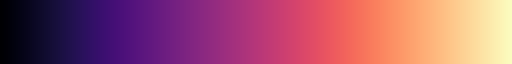

In [44]:
cmap = plt.get_cmap("magma")
colors = [cmap(i) for i in np.linspace(0, 1, 7)]
cmap

/tmp/ipykernel_153325/1169440912.py:20: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  lineplot = sns.lineplot(
/tmp/ipykernel_153325/1169440912.py:20: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  lineplot = sns.lineplot(


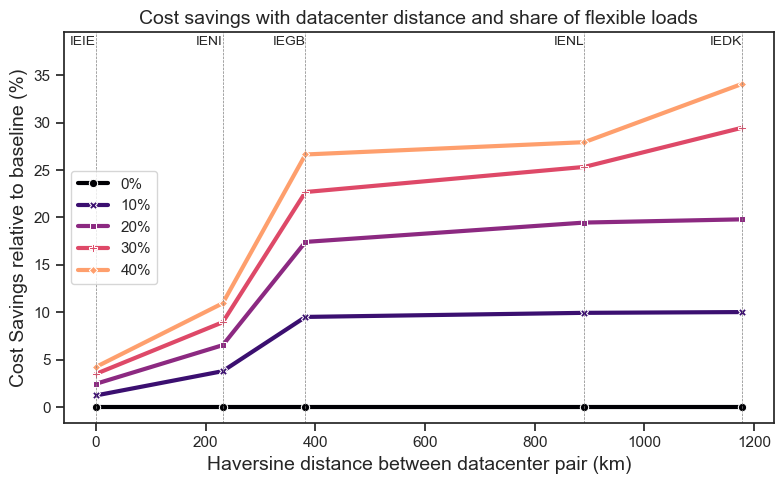

In [104]:
def plot_cost_savings(df):
    """
    Plot cost savings as a function of distance with different hues for each flexibility scenario using Seaborn.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Distance', 'Cost_Savings', and 'Flexibility' columns.
    """

    # Set the style
    sns.set(style="ticks")
    sns.set_context(rc={"lines.linewidth": 3})

    fig = plt.figure(figsize=(8, 5), dpi=100)

    # Generate a custom color palette from 'viridis'
    cmap = plt.get_cmap("magma")
    colors = cmap(np.linspace(0, 1, df["Flexibility"].nunique() + 1))

    # Create a line plot with the custom color palette
    lineplot = sns.lineplot(
        x="Distance",
        y="Cost_Savings",
        hue="Flexibility",
        style="Flexibility",
        data=df,
        markers=True,  # changed from "o" to True for compatibility
        dashes=False,
        palette=colors,  # Use the custom colors
    )

    # Set title and labels with specified font sizes
    plt.title(
        "Cost savings with datacenter distance and share of flexible loads", fontsize=14
    )
    plt.xlabel("Haversine distance between datacenter pair (km)", fontsize=14)
    plt.ylabel("Cost Savings relative to baseline (%)", fontsize=14)

    # Adjust the legend to show only line markers
    handles, labels = lineplot.get_legend_handles_labels()
    modified_labels = [
        label + "%" if not label.startswith("Flexibility") else label
        for label in labels
    ]

    # Modify labels if needed, keeping your customization
    plt.legend(
        loc="center left",
        fontsize="small",
        ncol=1,
        handles=handles,
        labels=modified_labels,
        prop={"size": 11},
    )

    # udjust Y-axis limits
    y_min, y_max = plt.gca().get_ylim()
    y_range = y_max - y_min
    new_y_max = y_max + y_range * 0.1
    plt.gca().set_ylim(y_min, new_y_max)

    # Filter DataFrame for unique Distance-Scenario pairs for one flexibility level
    unique_distances_scenarios = df.drop_duplicates(subset=["Distance", "Scenario"])

    for _, row in unique_distances_scenarios.iterrows():
        plt.axvline(x=row["Distance"], color="grey", linestyle="--", linewidth=0.5)
        label_y_position = (
            plt.gca().get_ylim()[1]
            - (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0]) * 0.01
        )  # 5% down from the top
        plt.text(
            row["Distance"],
            label_y_position,
            f"{row['Scenario']}",
            rotation=0,
            ha="right",
            va="top",
            fontsize=10,
        )

    #    plt.show()
    fig.tight_layout()
    fig.savefig(
        "../manuscript/img/distance-costs.pdf",
        transparent=True,
    )


plot_cost_savings(df_with_baseline)

### ### Cost savings VS wind feed-in correlation

In [68]:
ci_config = snakemake.config["ci"]


def get_datacenter_name(scenario, location_code):
    # Retrieve the datacenter mapping for the given scenario
    datacenter_mapping = ci_config[scenario]["datacenters"]
    return datacenter_mapping.get(location_code)


# Function to retrieve the base node for a scenario
def get_base_node(scenario):
    datacenters = ci_config[scenario]["datacenters"]
    return next(iter(datacenters))  # Always return the first datacenter

In [69]:
# Reset the index of 'df' to work with columns directly
df_reset = df.reset_index()

# Filter out the entries for 0% Flexibility
df_flex_zero = df_reset[df_reset["Flexibility"] == "0"]

# Group by 'Scenario' and sum up the 'CI_Total_Cost' for each scenario
# This gives the baseline cost for each scenario at 0% Flexibility
baseline_costs = (
    df_flex_zero.groupby("Scenario")
    .agg({"CI_Total_Cost": "sum"})
    .rename(columns={"CI_Total_Cost": "Baseline_Cost"})
)
baseline_costs

,Baseline_Cost
Scenario,
IEDK,372.2
IEGB,343.9
IEIE,219.4
IENI,414.7
IENL,388.4


In [72]:
enhanced_data = []
all_locations = df.index.get_level_values("Location").unique()


for (scenario, flexibility), group in df.groupby(["Scenario", "Flexibility"]):
    n = pypsa.Network(
        f"../{folder}/networks/2025/p1/cfe100/{scenario}/{flexibility}.nc"
    )
    # Fetch the baseline cost for the scenario
    baseline_cost = (
        baseline_costs.loc[scenario, "Baseline_Cost"]
        if scenario in baseline_costs.index
        else np.nan
    )

    base_node = get_base_node(scenario)

    if len(ci_config[scenario]["datacenters"]) == 1:
        # Handle scenario with single datacenter
        enhanced_data.append(
            (
                scenario,
                flexibility,
                base_node,
                base_node,
                0,
                group["CI_Total_Cost"].sum(),
                1,
                0,
            )
        )
        continue

    datacenter_name_1 = get_datacenter_name(scenario, base_node)
    if datacenter_name_1 is None:
        continue

    wind_series_1 = analyze_datacenter_shifts(
        n, dc1=datacenter_name_1, dc2=datacenter_name_1
    )[datacenter_name_1]["potentials"][f"{datacenter_name_1} onwind"]

    for loc2 in all_locations:
        if base_node != loc2:
            datacenter_name_2 = get_datacenter_name(scenario, loc2)
            if datacenter_name_2 is None:
                continue

            wind_series_2 = analyze_datacenter_shifts(
                n, dc1=datacenter_name_2, dc2=datacenter_name_2
            )[datacenter_name_2]["potentials"][f"{datacenter_name_2} onwind"]
            correlation = np.corrcoef(wind_series_1, wind_series_2)[0, 1]

            mean_distance = group.xs(base_node, level="Location")["Distance"].mean()
            total_cost = group["CI_Total_Cost"].sum()

            # Corrected cost savings calculation
            if pd.notna(baseline_cost) and pd.notna(total_cost):
                cost_savings = 100 * (baseline_cost - total_cost) / baseline_cost
                cost_savings = round(cost_savings, 2)
            else:
                cost_savings = np.nan

            enhanced_data.append(
                (
                    scenario,
                    flexibility,
                    base_node,
                    loc2,
                    mean_distance,
                    total_cost,
                    correlation,
                    cost_savings,
                    baseline_cost,
                )
            )

df_enhanced = pd.DataFrame(
    enhanced_data,
    columns=[
        "Scenario",
        "Flexibility",
        "Location",
        "Other_Location",
        "Mean_Distance",
        "Total_Cost",
        "Wind_Correlation",
        "Cost_Savings",
        "Baseline_Cost",
    ],
)

INFO:pypsa.io:Imported network 0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 10.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 20.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 30.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 10.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network 20.nc has buses, carriers, generators, g

In [73]:
df_enhanced

,Scenario,Flexibility,Location,Other_Location,Mean_Distance,Total_Cost,Wind_Correlation,Cost_Savings,Baseline_Cost
0,IEDK,0,IE5 0,DK1 0,1177.3,372.2,0.214470,0.00,372.2
1,IEDK,10,IE5 0,DK1 0,1177.3,334.9,0.214470,10.02,372.2
2,IEDK,20,IE5 0,DK1 0,1177.3,298.5,0.214470,19.80,372.2
3,IEDK,30,IE5 0,DK1 0,1177.3,262.6,0.214470,29.45,372.2
4,IEDK,40,IE5 0,DK1 0,1177.3,245.4,0.214470,34.07,372.2
5,IEGB,0,IE5 0,GB0 0,381.9,343.9,0.720671,0.00,343.9
6,IEGB,10,IE5 0,GB0 0,381.9,311.2,0.720671,9.51,343.9
7,IEGB,20,IE5 0,GB0 0,381.9,284.0,0.720671,17.42,343.9
8,IEGB,30,IE5 0,GB0 0,381.9,265.9,0.720671,22.68,343.9
9,IEGB,40,IE5 0,GB0 0,381.9,252.3,0.720671,26.64,343.9


/tmp/ipykernel_153325/1169425603.py:17: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  lineplot = sns.lineplot(
/tmp/ipykernel_153325/1169425603.py:17: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  lineplot = sns.lineplot(


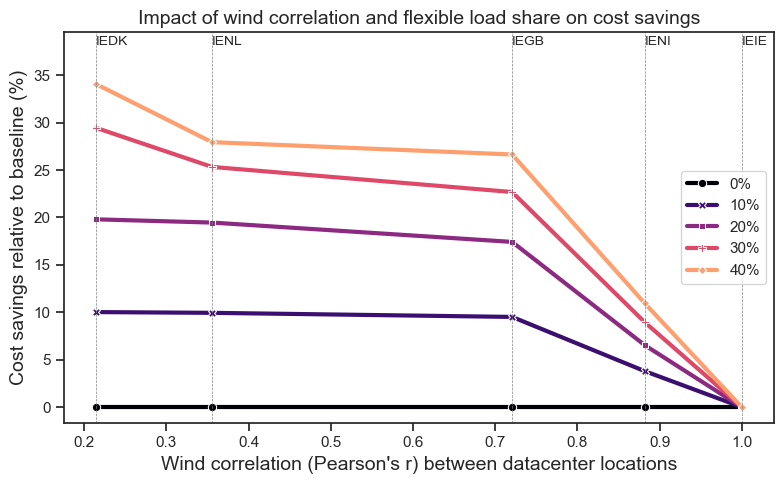

In [106]:
def plot_cost_savings_correlation(df):
    """
    Plot cost savings as a function of wind correlation for each flexibility scenario.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Wind_Correlation', 'Cost_Savings', and 'Flexibility' columns.
    """

    sns.set(style="ticks")
    sns.set_context(rc={"lines.linewidth": 3})

    cmap = plt.get_cmap("magma")
    colors = cmap(np.linspace(0, 1, df["Flexibility"].nunique() + 1))

    plt.figure(figsize=(8, 5), dpi=100)

    lineplot = sns.lineplot(
        x="Wind_Correlation",
        y="Cost_Savings",
        hue="Flexibility",
        style="Flexibility",
        data=df,
        markers=True,  # changed from "o" to True for compatibility
        dashes=False,
        palette=colors,
    )

    plt.title(
        "Impact of wind correlation and flexible load share on cost savings",
        fontsize=14,
    )
    plt.xlabel(
        "Wind correlation (Pearson's r) between datacenter locations", fontsize=14
    )
    plt.ylabel("Cost savings relative to baseline (%)", fontsize=14)

    handles, labels = lineplot.get_legend_handles_labels()
    modified_labels = [
        label + "%" if not label.startswith("Flexibility") else label
        for label in labels
    ]
    plt.legend(
        loc="center right",
        fontsize="small",
        ncol=1,
        handles=handles,
        labels=modified_labels,
        prop={"size": 11},
    )

    # Adjust Y-axis limits
    y_min, y_max = plt.gca().get_ylim()
    y_range = y_max - y_min
    new_y_max = y_max + y_range * 0.1
    plt.gca().set_ylim(y_min, new_y_max)

    unique_correlations = df[df["Flexibility"] == "0"].drop_duplicates(
        subset=["Wind_Correlation"]
    )

    for _, row in unique_correlations.iterrows():
        plt.axvline(
            x=row["Wind_Correlation"], color="grey", linestyle="--", linewidth=0.5
        )
        label_y_position = y_max + y_range * 0.09
        plt.text(
            row["Wind_Correlation"],
            label_y_position,
            f"{row['Scenario']}",
            rotation=0,
            ha="left",
            va="top",
            fontsize=10,
        )

    plt.tight_layout()
    plt.savefig("../manuscript/img/wind_correlation-costs.pdf", transparent=True)

    # plt.show()


# plot_cost_savings_correlation(df)  # Uncomment and replace 'df' with your actual DataFrame variable name to use the function
plot_cost_savings_correlation(df_enhanced)

In [92]:
unique_correlations = df[df["Flexibility"] == "0"].drop_duplicates(
    subset=["Wind_Correlation"]
)
unique_correlations

,Scenario,Flexibility,Location,Other_Location,Mean_Distance,Total_Cost,Wind_Correlation,Cost_Savings,Baseline_Cost
0,IEDK,0,IE5 0,DK1 0,1177.3,372.2,0.214470,0.0,372.2
5,IEGB,0,IE5 0,GB0 0,381.9,343.9,0.720671,0.0,343.9
10,IEIE,0,IE5 0,IE5 0,0.0,219.4,1.000000,0.0,NaN
15,IENI,0,IE5 0,GB5 0,231.0,414.7,0.882050,0.0,414.7
20,IENL,0,IE5 0,NL1 0,890.6,388.4,0.355529,0.0,388.4
